<a href="https://colab.research.google.com/github/nlp26/making-sense/blob/main/tweet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando e importando as libs

In [ ]:
!pip install unidecode
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk
import spacy
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
nltk.download('punkt')
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob as tb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from string import punctuation
from wordcloud import WordCloud
from unidecode import unidecode

from nltk import word_tokenize
from nltk.corpus import stopwords

from transformers import pipeline
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from spacy.lang.pt.stop_words import STOP_WORDS
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Carregando e explorando dataset sem tema

In [ ]:
dfnt = pd.read_csv('/content/NoThemeTweets.csv', encoding='utf-8', index_col=0)
dfnt.head()

,tweet_text,tweet_date,sentiment,query_used
id,,,,
1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:)
1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:)
1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,:)
1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:)
1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,Positivo,:)


In [ ]:
dfnt.shape

(785814, 4)

In [ ]:
#dfnt.isna().sum()
np.sum(dfnt.isnull())

tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [ ]:
dfnt.info()
#dfnt.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785814 entries, 1031761728445530112 to 1050704920922521601
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  785814 non-null  object
 1   tweet_date  785814 non-null  object
 2   sentiment   785814 non-null  object
 3   query_used  785814 non-null  object
dtypes: object(4)
memory usage: 30.0+ MB


In [ ]:
dfnt['sentiment'].unique()

array(['Positivo', 'Negativo'], dtype=object)

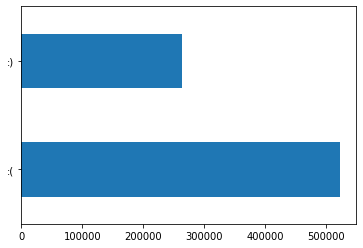

In [ ]:
dfnt["query_used"].value_counts().plot.barh()

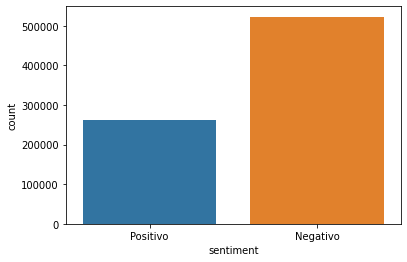

In [ ]:
sns.countplot(x='sentiment', data=dfnt)

# Carregando e explorando dataset com tema

In [ ]:
dfwt = pd.read_csv('/content/TweetsWithTheme.csv', encoding='utf-8', index_col=0)
dfwt.head()

,tweet_text,tweet_date,sentiment,query_used
id,,,,
1026606627041026050,ela vendo a família :( FUGIDINHA VERA LÚCIA,Mon Aug 06 23:11:07 +0000 2018,Negativo,vera lucia :(
1026266117646561281,Eu odeio o fato que muito provavelmente meu vo...,Mon Aug 06 00:38:04 +0000 2018,Negativo,ciro :(
1025889796097564672,"Ciro ""mita"" tanto quanto aquele outro, não que...",Sat Aug 04 23:42:42 +0000 2018,Negativo,ciro :(
1026960047937646598,Raiva do Bolsonaro agora :),Tue Aug 07 22:35:30 +0000 2018,Positivo,bolsonaro :)
1026447105932623872,Reflexos da alienação petista comandada por Lu...,Mon Aug 06 12:37:15 +0000 2018,Negativo,lula :(


In [ ]:
dfwt.shape

(61591, 4)

In [ ]:
#dfnt.isna().sum()
np.sum(dfnt.isnull())

tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [ ]:
dfwt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61591 entries, 1026606627041026050 to 1055068278882791425
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  61591 non-null  object
 1   tweet_date  61591 non-null  object
 2   sentiment   61591 non-null  object
 3   query_used  61591 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


In [ ]:
np.sum(dfwt.isnull().any(axis=1))

0

In [ ]:
dfwt['sentiment'].unique()

array(['Negativo', 'Positivo'], dtype=object)

In [ ]:
dfwt['sentiment'].str.contains('neutro', na=False, flags=re.IGNORECASE)

id
1026606627041026050    False
1026266117646561281    False
1025889796097564672    False
1026960047937646598    False
1026447105932623872    False
                       ...  
1055096632600080384    False
1055204789058002949    False
1054982223793938433    False
1055144918451187714    False
1055068278882791425    False
Name: sentiment, Length: 61591, dtype: bool

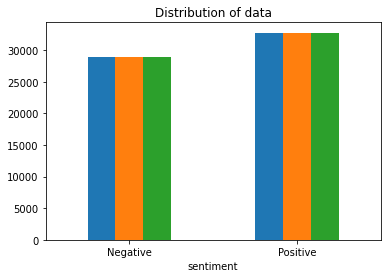

In [ ]:
ax = dfwt.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(dfwt['tweet_text']), list(dfwt['sentiment'])

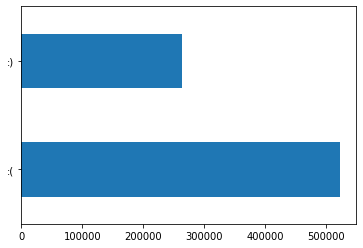

In [ ]:
dfnt["query_used"].value_counts().plot.barh()

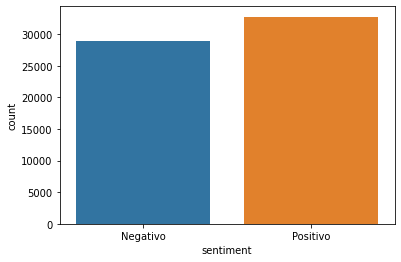

In [ ]:
sns.countplot(x='sentiment', data=dfwt)

# Preparando modelo de sentiment analysis

In [ ]:
sentiment_model = pipeline(model="turing-usp/FinBertPTBR")
sentiment_model(["O Ibovespa acompanha correção do mercado e fecha com alta moderada", "tivemos baixa na bolsa nos últimos dias"])


Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.8854228854179382},
 {'label': 'NEGATIVE', 'score': 0.8358221650123596}]

In [ ]:
#df = pd.read_csv('/content/TweetsWithTheme.csv')
#df.rename(columns={'tweet_text':'text', 'tweet_date':'date', 'query_used':'query'}, inplace=True)
#df['text'], df['sentiment'] = df['text'].apply(lambda x: re.sub('(@)|((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))[A-Za-z0-9_]+','', unidecode(str(word_tokenize(x)).lower()))), df['sentiment'].str.lower()
#df

In [ ]:
df = pd.read_csv('/content/TweetsWithTheme.csv')
df.rename(columns={'tweet_text':'text', 'tweet_date':'date', 'query_used':'query'}, inplace=True)
df['text'], df['sentiment'] = df['text'].apply(lambda x: re.sub('(@)|((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))[A-Za-z0-9_]+','', unidecode(str(x).lower()))), df['sentiment'].str.lower()
df.head()

,id,text,date,sentiment,query
0,1026606627041026050,ela vendo a familia :( fugidinha vera lucia,Mon Aug 06 23:11:07 +0000 2018,negativo,vera lucia :(
1,1026266117646561281,eu odeio o fato que muito provavelmente meu vo...,Mon Aug 06 00:38:04 +0000 2018,negativo,ciro :(
2,1025889796097564672,"ciro ""mita"" tanto quanto aquele outro, nao que...",Sat Aug 04 23:42:42 +0000 2018,negativo,ciro :(
3,1026960047937646598,raiva do bolsonaro agora :),Tue Aug 07 22:35:30 +0000 2018,positivo,bolsonaro :)
4,1026447105932623872,reflexos da alienacao petista comandada por lu...,Mon Aug 06 12:37:15 +0000 2018,negativo,lula :(


In [ ]:
df.sentiment.value_counts()

positivo    32744
negativo    28847
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


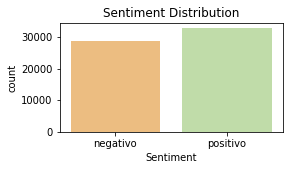

In [ ]:
plt.figure(figsize=(4, 2))
sns.countplot(df.sentiment, palette='Spectral')
plt.xlabel('Sentiment')
plt.title('Sentiment Distribution');

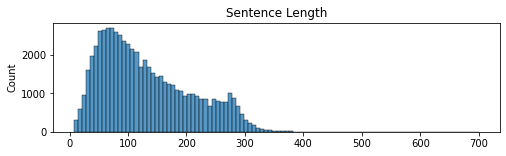

In [ ]:
plt.figure(figsize=(8, 2))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
max_len = max([len(sent) for sent in df.text])
print('Max: ', max_len)

Max:  701


In [ ]:
min_len = min([len(sent) for sent in df.text])
print('Min: ', min_len)

Min:  7


In [ ]:
binary_labels = df.sentiment.unique()

In [ ]:
label_dict = {}
for index, binary_labels in enumerate(binary_labels):
    label_dict[binary_labels] = index

In [ ]:
df['label'] = df.sentiment.replace(label_dict)
df.head()

,id,text,date,sentiment,query,label
0,1026606627041026050,ela vendo a familia :( fugidinha vera lucia,Mon Aug 06 23:11:07 +0000 2018,negativo,vera lucia :(,0
1,1026266117646561281,eu odeio o fato que muito provavelmente meu vo...,Mon Aug 06 00:38:04 +0000 2018,negativo,ciro :(,0
2,1025889796097564672,"ciro ""mita"" tanto quanto aquele outro, nao que...",Sat Aug 04 23:42:42 +0000 2018,negativo,ciro :(,0
3,1026960047937646598,raiva do bolsonaro agora :),Tue Aug 07 22:35:30 +0000 2018,positivo,bolsonaro :),1
4,1026447105932623872,reflexos da alienacao petista comandada por lu...,Mon Aug 06 12:37:15 +0000 2018,negativo,lula :(,0


In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df.label.values,
                                                   test_size = 2,
                                                   random_state = 20,
                                                   stratify = df.label.values)

In [ ]:
df['data_type'] = ['null'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['sentiment', 'label', 'data_type']).count()

id   text   date  query
sentiment label data_type                            
negativo  0     train      28846  28846  28846  28846
                val            1      1      1      1
positivo  1     train      32743  32743  32743  32743
                val            1      1      1      1

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                         do_lower_case = True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

{'input_ids': tensor([[  101,   740, 16649,  ...,     0,     0,     0],
        [  101,  2779,   146,  ...,     0,     0,     0],
        [  101,  1793, 22280,  ...,     0,     0,     0],
        ...,
        [  101,   149, 22314,  ...,     0,     0,     0],
        [  101,   179,  5664,  ...,     0,     0,     0],
        [  101,   368,  7139,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [ ]:
input_ids_train

tensor([[  101,   740, 16649,  ...,     0,     0,     0],
        [  101,  2779,   146,  ...,     0,     0,     0],
        [  101,  1793, 22280,  ...,     0,     0,     0],
        ...,
        [  101,   149, 22314,  ...,     0,     0,     0],
        [  101,   179,  5664,  ...,     0,     0,     0],
        [  101,   368,  7139,  ...,     0,     0,     0]])

In [ ]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
labels_train

tensor([0, 0, 0,  ..., 1, 0, 1])

In [ ]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

61589
2


In [ ]:
dataset_train.tensors

(tensor([[  101,   740, 16649,  ...,     0,     0,     0],
         [  101,  2779,   146,  ...,     0,     0,     0],
         [  101,  1793, 22280,  ...,     0,     0,     0],
         ...,
         [  101,   149, 22314,  ...,     0,     0,     0],
         [  101,   179,  5664,  ...,     0,     0,     0],
         [  101,   368,  7139,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 1, 0, 1]))

In [ ]:
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
model.config

BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 29794
}

In [ ]:
batch_size = 4 

dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) 

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs.loss
        logits = outputs.logits
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
#train model

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss_train_total +=loss.item()

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15398 [00:00<?, ?it/s]

In [ ]:
outputs.loss

In [ ]:
outputs.logits

In [ ]:
model.to(device)
pass

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)

In [ ]:
accuracy_per_class(predictions, true_vals)

# Alternative libs

In [ ]:
df = pd.read_csv('/content/TweetsWithTheme.csv')
df.rename(columns={'tweet_text':'text', 'tweet_date':'date', 'query_used':'query'}, inplace=True)
df['text'], df['sentiment'], df = df['text'].apply(lambda x: re.sub('(@)|((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))[A-Za-z0-9_]+','', unidecode(str(x).lower()))), df['sentiment'].str.lower()
df

In [ ]:
sentiment_objects = [tb(tweet) for tweet in df['text']]
sentiment_objects[0].polarity, sentiment_objects[0]

In [ ]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
sentiment_values[0]

In [ ]:
sentiment_values[0:99]

In [ ]:
def word_cloud(text):
    all_words = ' '.join([sent for sent in text])
    wcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(24,12))
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
word_cloud(df['text'])